In [1]:
import torch
import random
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# loading dataset
words = open(r"data\names.txt").read().splitlines()
print(f"Number of words: {len(words)}")
print(f"first 5 words: {words[:5]}")

Number of words: 55272
first 5 words: ['parish', 'manhi', 'akshaykeerti', 'suran', 'tomali']


In [3]:
# creating a look up table (dictionary to map int to characters and vice versa)
chars = sorted(list(set(''.join(words))))
ch_to_id = {ch:i+1 for i, ch in enumerate(chars)}
ch_to_id['.'] = 0 # special char to mark ending and starting of a word
vocab_size = len(ch_to_id)
id_to_ch = {i:ch for ch, i in ch_to_id.items()}
print(f"Charecters to id: {ch_to_id}")
print(f"Id to charecters: {id_to_ch}")
print(f"Vocab size: {vocab_size}")

Charecters to id: {'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
Id to charecters: {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
Vocab size: 27


In [4]:
# building our datasets: training split(80%), dev/validation split(10%) and test split(10%)

block_size = 3 # context length: how many charecters to consider to predict the next charecter
def buid_dataset(words, str):
    X, Y = [], [] # X: context, Y: target
    for word in words:
        context = [0] * block_size
        for ch in word + ".": # adding a special char to mark the end of a word
            current_idx = ch_to_id[ch]
            X.append(context)
            Y.append(current_idx)
            context = context[1:] + [current_idx] # sliding the context window
            
    # converting the dataset to tensors        
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f"\nX_{str} shape: {X.shape}")
    print(f"Y_{str} shape: {Y.shape}")
    return X, Y

random.shuffle(words)
lim1 = int(len(words) * 0.8)
lim2 = int(len(words) * 0.9)

X_train, Y_train = buid_dataset(words[:lim1], "train")
X_dev, Y_dev = buid_dataset(words[lim1:lim2], "dev")
X_test, Y_test = buid_dataset(words[lim2:], "test")


X_train shape: torch.Size([401612, 3])
Y_train shape: torch.Size([401612])

X_dev shape: torch.Size([50170, 3])
Y_dev shape: torch.Size([50170])

X_test shape: torch.Size([50185, 3])
Y_test shape: torch.Size([50185])


In [44]:
# Pytorchyfying elmo 2.0

# Linear class
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaming init
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# BatchNorm class
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
# Activation class
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [45]:
# initialization
num_embd = 10 # embedding vector dimensions
num_hidden = 100 # num neurons hidden layer

C = torch.randn((vocab_size, num_embd))
layers = [
  Linear(num_embd * block_size, num_hidden, bias=False),
  BatchNorm1d(num_hidden),
  Tanh(),
  Linear(num_hidden, num_hidden, bias=False),
  BatchNorm1d(num_hidden),
  Tanh(),
  Linear(num_hidden, num_hidden, bias=False),
  BatchNorm1d(num_hidden),
  Tanh(),
  Linear(num_hidden, num_hidden, bias=False),
  BatchNorm1d(num_hidden),
  Tanh(),
  Linear(num_hidden, num_hidden, bias=False),
  BatchNorm1d(num_hidden),
  Tanh(),
  Linear(num_hidden, vocab_size, bias=False),
  BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [46]:
# optimization
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # minibatches
  idx = torch.randint(0, X_train.shape[0], (batch_size,))
  mini_X, mini_Y = X_train[idx], Y_train[idx] # batch X,Y
  
  # forward pass
  embeddings = C[mini_X] # embed cahr in vectors
  x = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, mini_Y) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
print(f"Final loss: {loss}")

      0/ 200000: 3.2903
  10000/ 200000: 2.4721
  20000/ 200000: 2.3381
  30000/ 200000: 2.0154
  40000/ 200000: 1.8248
  50000/ 200000: 2.1291
  60000/ 200000: 2.1893
  70000/ 200000: 1.8605
  80000/ 200000: 1.7594
  90000/ 200000: 1.8919
 100000/ 200000: 2.0650
 110000/ 200000: 2.1283
 120000/ 200000: 1.5683
 130000/ 200000: 2.1528
 140000/ 200000: 2.1083
 150000/ 200000: 1.8658
 160000/ 200000: 1.7811
 170000/ 200000: 1.6673
 180000/ 200000: 1.7591
 190000/ 200000: 2.3291
Final loss: 2.089329481124878


layer 2 (      Tanh): mean +0.01, std 0.70, saturated: 13.25%
layer 5 (      Tanh): mean +0.02, std 0.74, saturated: 15.03%
layer 8 (      Tanh): mean +0.02, std 0.76, saturated: 15.66%
layer 11 (      Tanh): mean -0.01, std 0.77, saturated: 18.03%
layer 14 (      Tanh): mean -0.01, std 0.78, saturated: 17.62%


Text(0.5, 1.0, 'activation distribution')

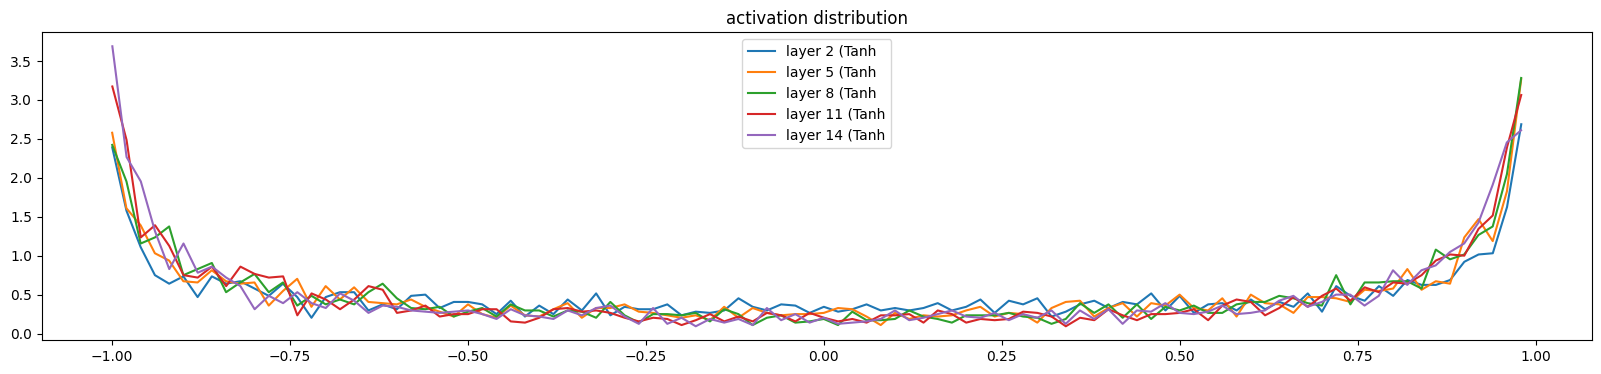

In [49]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('activation distribution')

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 1.274370e-02 | grad:data ratio 1.155865e-02
weight  (30, 100) | mean +0.000064 | std 7.402172e-03 | grad:data ratio 1.832879e-02
weight (100, 100) | mean +0.000019 | std 4.456225e-03 | grad:data ratio 1.825222e-02
weight (100, 100) | mean +0.000011 | std 4.561927e-03 | grad:data ratio 1.877631e-02
weight (100, 100) | mean +0.000030 | std 4.516754e-03 | grad:data ratio 1.885556e-02
weight (100, 100) | mean -0.000001 | std 4.601762e-03 | grad:data ratio 1.946808e-02
weight  (100, 27) | mean +0.000032 | std 8.360819e-03 | grad:data ratio 2.382891e-02


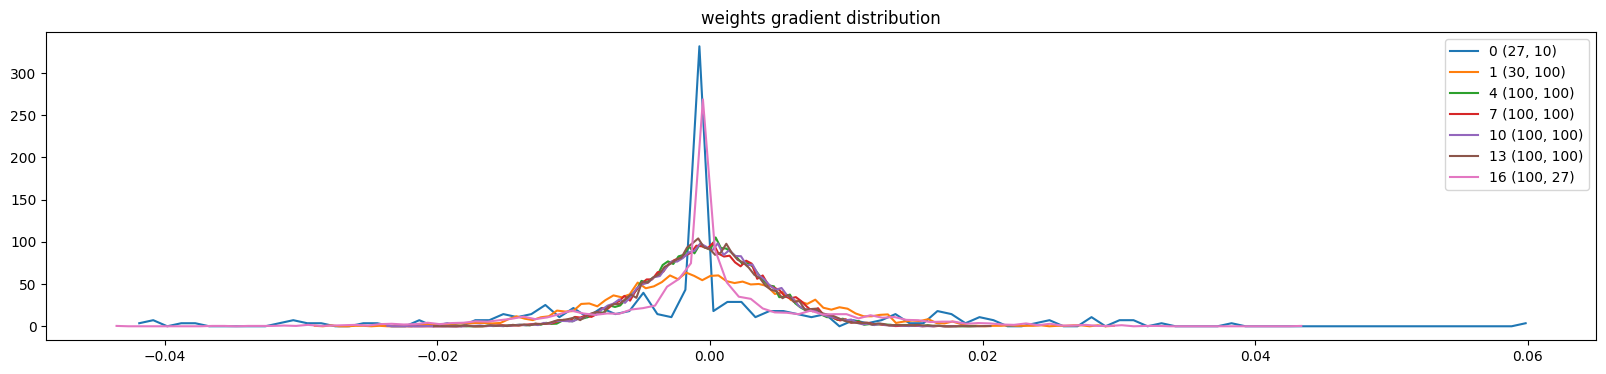

In [51]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

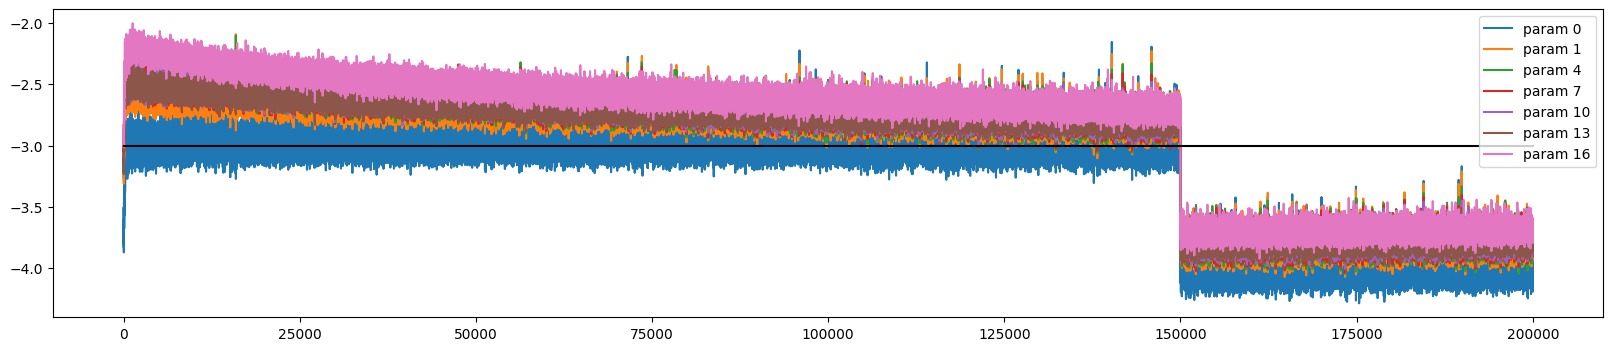

In [52]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)

In [53]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, Y_train),
    'val': (X_dev, Y_dev),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 1.8811579942703247
val 1.9018367528915405


In [54]:
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(id_to_ch[i] for i in out)) # decode and print the generated word

kavinayathkumar.
sam.
ochichrigodharravi.
sara.
elli.
janth.
basthirthikka.
stimith.
sree.
leerthini.
pooban.
mahamithavarshana.
amilan.
saiga.
monalinakhini.
meerapragenthyahitika.
dhan.
asa.
ana.
theesh.
